In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adadelta, Adam
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def imagegen(train_path, valid_path, test_path, batch_size):
    
    '''
    Image generator function 
    
    Parameters:
    train_path - path to the training data set
    valid_path - path to the validation data set
    test_path - path to the test data set
    batch_size - batch size 
    
    
    return: (train_generator, validation_generator, testing_generator)  
    - training image generator, validation image generator, testing image generator
    '''
    # training images augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,validation_split=0.2)
    
    # validation augmentation
    valid_datagen = ImageDataGenerator(rescale=1./255)# only rescaling
    
    # test augmentation
    test_datagen = ImageDataGenerator(rescale=1./255)# only rescaling
    
    # generator that read into subfolders of 'data/train'
    train_generator = train_datagen.flow_from_directory(
        train_path,  # this is the target directory
        target_size=image_size,  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical',subset='training')  # since categorical_crossentropy loss is used, we need binary labels

    # this is a similar generator, for validation data
    '''validation_generator = valid_datagen.flow_from_directory(
            valid_path,
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical')'''
    validation_generator = train_datagen.flow_from_directory(
            train_path,  # this is the target directory
            target_size=image_size,  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode='categorical',subset='validation')
    
    testing_generator = test_datagen.flow_from_directory(
            test_path,
            target_size=image_size,
            batch_size=batch_size,
            shuffle = False,
            class_mode='categorical')
    return train_generator, validation_generator, testing_generator

In [4]:
# training model

def fit(model, model_name, image_generator, batch_size, epochs, no_train_img, no_valid_img):
    
    '''
    training function to rain CNN model 
    
    Parameters:
    
    model - CNN model
    model_name - model name to save data 
    image_generator - generator to generate train/validation images
    batch_size - batch size
    epochs - number of epochs 
    no_train_img - number of training images
    no_valid_img - number of validation images
    '''
    
    #tensorboard
    print(model.summary())
    tbc = TensorBoard(log_dir='/output/{}'.format(model_name), 
                      histogram_freq=0, write_graph=True, write_images=True)
    
    history =model.fit_generator(
        image_generator[0],
        steps_per_epoch=no_train_img // batch_size,
        epochs=epochs,
        validation_data=image_generator[1],
        validation_steps=no_valid_img // batch_size,callbacks=[tbc]  )
    
    #save
    model.save('{}.h5'.format(model_name)) 
    model.save_weights('{}_weights.h5'.format(model_name)) 
    
    #plot
    
    # Loss Curves
    plt.figure(figsize=[8,6]);
    plt.plot(history.history['loss'],'r',linewidth=3.0);
    plt.plot(history.history['val_loss'],'b',linewidth=3.0);
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18);
    plt.xlabel('Epochs ',fontsize=16);
    plt.ylabel('Loss',fontsize=16);
    plt.title('Loss Curves {}'.format(model_name),fontsize=16);
   

    # Accuracy Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['acc'],'r',linewidth=3.0);
    plt.plot(history.history['val_acc'],'b',linewidth=3.0);
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18);
    plt.xlabel('Epochs ',fontsize=16);
    plt.ylabel('Accuracy',fontsize=16);
    plt.title('Accuracy Curves {}'.format(model_name),fontsize=16);
   

    print(history.history['val_acc'][-1])

In [5]:
# testing model 
import itertools
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report


#plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap='cividis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#test function
    
def predict(model,model_name,image_generator,no_images,batch_size):
    
    '''
    Test function to test the CNN model 
    
    
    model - CNN model
    model_name - model name to save data 
    image_generator - image generator to generate test images
    batch_size = batch size 
    
    
    
    '''
    dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
    steps=no_images/batch_size
    predictions = model.predict_generator(image_generator[2],steps=steps)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = image_generator[2].classes
    class_labels = list(image_generator[2].class_indices.keys())
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)  
    cm =confusion_matrix(true_classes, predicted_classes)
    cm_plot_labels = list(image_generator[2].class_indices.keys()) 
    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix {}'.format(model_name))

In [6]:
#parameters
batch_size = 32
image_size = (80, 60)
input_shape = (80, 60, 3)
epochs = 50

#specify paths for train and test sets
train_path = 'C:/Users/shuaix/Dropbox/Data_Science/Final_Capstone/blood-cells/dataset-master/dataset-master/data/TRAIN'
test_path = 'C:/Users/shuaix/Dropbox/Data_Science/Final_Capstone/blood-cells/dataset-master/dataset-master/data/TEST'
valid_path = 'C:/Users/shuaix/Dropbox/Data_Science/Final_Capstone/blood-cells/dataset-master/dataset-master/data/TRAIN'

if not os.path.exists(train_path):
    raise Exception('No train folder found')

if not os.path.exists(test_path):
    raise Exception('No test folder found')

In [7]:
image_generator=imagegen(train_path,valid_path,test_path,batch_size)

Found 7087 images belonging to 4 classes.
Found 1769 images belonging to 4 classes.
Found 2441 images belonging to 4 classes.


# CNN Models

## Model 1

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7488)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               958592    
_________________________________________________________________
dens

Epoch 48/50
221/221 [==============================] - 68s 307ms/step - loss: 0.3028 - acc: 0.8771 - val_loss: 0.2586 - val_acc: 0.8900
Epoch 49/50
221/221 [==============================] - 68s 307ms/step - loss: 0.2954 - acc: 0.8770 - val_loss: 0.4025 - val_acc: 0.8336
Epoch 50/50
221/221 [==============================] - 67s 303ms/step - loss: 0.2945 - acc: 0.8777 - val_loss: 0.2875 - val_acc: 0.8826
0.8825561312951091


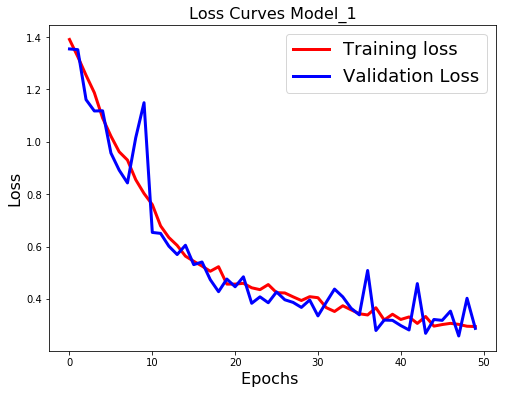

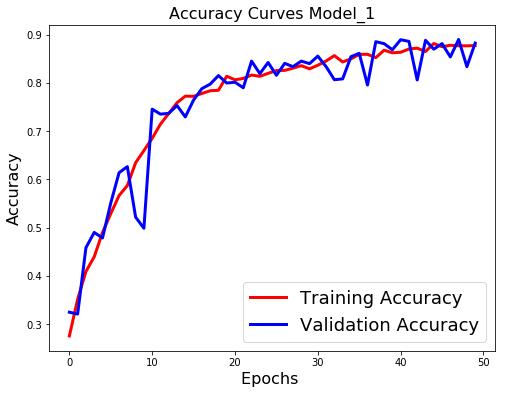

In [7]:
model_name = 'Model_1'
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(4, activation='softmax'))
model1.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model1, model_name, image_generator, batch_size, epochs, 7087, 1769)

              precision    recall  f1-score   support

  EOSINOPHIL       0.89      0.87      0.88       617
  LYMPHOCYTE       0.96      0.98      0.97       599
    MONOCYTE       0.94      0.98      0.96       621
  NEUTROPHIL       0.88      0.84      0.86       604

   micro avg       0.92      0.92      0.92      2441
   macro avg       0.92      0.92      0.92      2441
weighted avg       0.92      0.92      0.92      2441

Confusion matrix, without normalization
[[535  10  10  62]
 [  3 585   7   4]
 [  1   3 611   6]
 [ 60  12  23 509]]


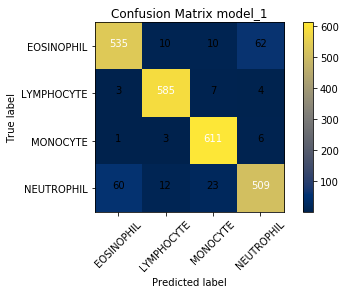

In [8]:
predict(model1 ,'model_1',image_generator,2441,batch_size)

## Model 2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2560)              0         
__________

221/221 [==============================] - 79s 359ms/step - loss: 0.3220 - acc: 0.8666 - val_loss: 0.2631 - val_acc: 0.8958
0.8957973517902157


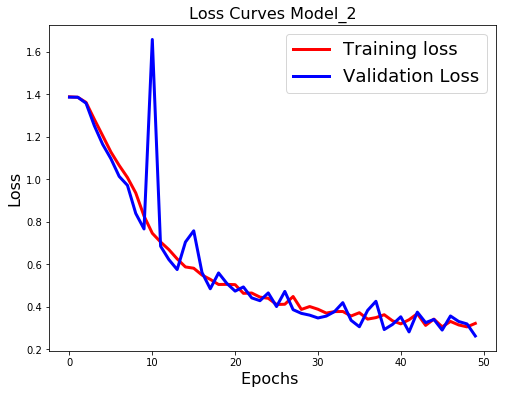

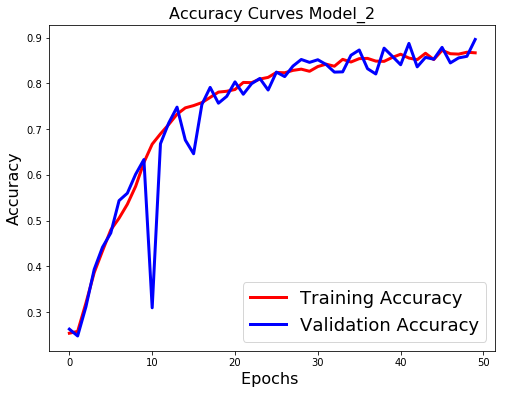

In [9]:
model_name = 'Model_2'
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
#extra CRP
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(4, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model2, model_name, image_generator, batch_size, epochs, 7087, 1769)

              precision    recall  f1-score   support

  EOSINOPHIL       0.85      0.81      0.83       617
  LYMPHOCYTE       0.91      0.93      0.92       599
    MONOCYTE       0.91      0.92      0.92       621
  NEUTROPHIL       0.81      0.82      0.81       604

   micro avg       0.87      0.87      0.87      2441
   macro avg       0.87      0.87      0.87      2441
weighted avg       0.87      0.87      0.87      2441

Confusion matrix, without normalization
[[502  39   6  70]
 [  3 559  32   5]
 [  5   2 574  40]
 [ 78  14  19 493]]


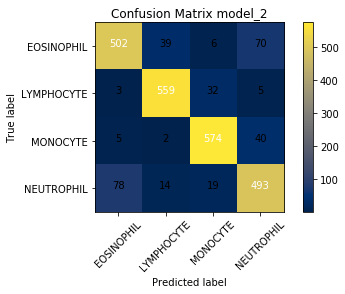

In [10]:
predict(model2 ,'model_2',image_generator,2441,batch_size)

## Model 3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 3, 64)          36928     
__________

312/312 [==============================] - 92s 295ms/step - loss: 0.2908 - acc: 0.8760 - val_loss: 0.3304 - val_acc: 0.8531
Epoch 49/50
312/312 [==============================] - 92s 296ms/step - loss: 0.2935 - acc: 0.8762 - val_loss: 0.3153 - val_acc: 0.8638
Epoch 50/50
312/312 [==============================] - 92s 294ms/step - loss: 0.3063 - acc: 0.8719 - val_loss: 0.2874 - val_acc: 0.8730
0.87302396736359


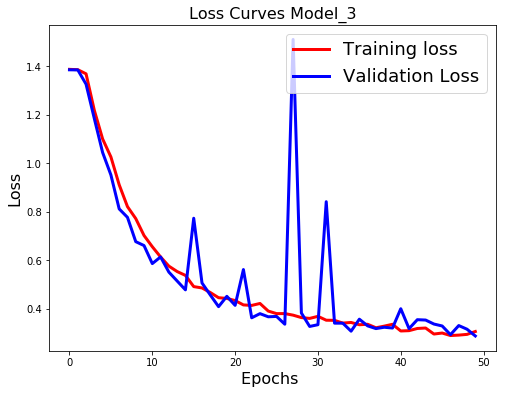

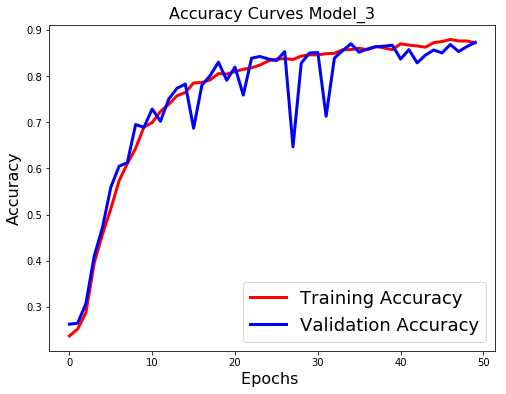

In [11]:
model_name = 'Model_3'
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
#extra CRP
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(4, activation='softmax'))
model3.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model3, model_name, image_generator, batch_size, epochs, 10000, 2000)

              precision    recall  f1-score   support

  EOSINOPHIL       0.74      0.82      0.78       617
  LYMPHOCYTE       0.85      0.85      0.85       599
    MONOCYTE       0.85      0.88      0.87       621
  NEUTROPHIL       0.82      0.71      0.76       604

   micro avg       0.82      0.82      0.82      2441
   macro avg       0.82      0.82      0.82      2441
weighted avg       0.82      0.82      0.82      2441

Confusion matrix, without normalization
[[507  69   5  36]
 [ 23 508  63   5]
 [ 18   4 548  51]
 [135  15  25 429]]


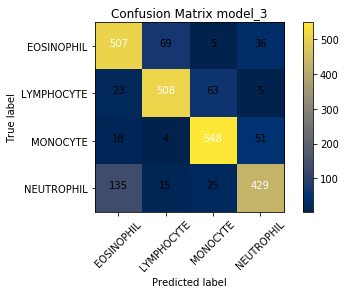

In [12]:
predict(model3 ,'model_3',image_generator,2441,batch_size)

## Model 4

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2560)              0         
__________

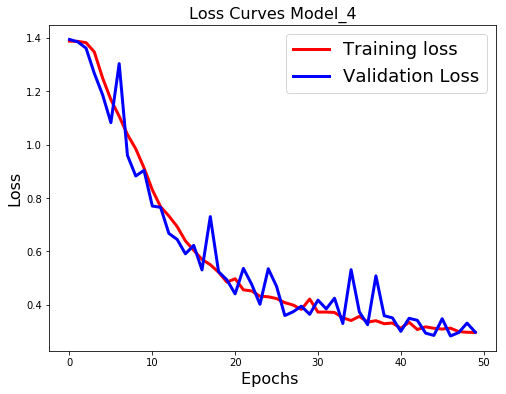

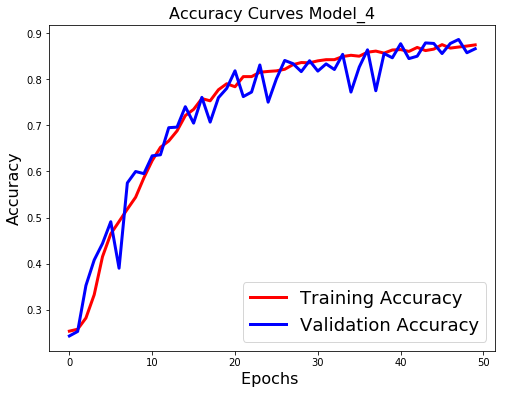

In [13]:
#model 4
model_name = 'Model_4'
model4 = Sequential()
model4.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(32, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))


model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))


model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
#add extra Dense layer
model4.add(Dense(128, activation='relu'))
model4.add(Dense(4, activation='softmax'))
model4.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model4, model_name, image_generator, batch_size, epochs, 9957, 2487)

              precision    recall  f1-score   support

  EOSINOPHIL       0.74      0.68      0.71       617
  LYMPHOCYTE       0.81      0.82      0.82       599
    MONOCYTE       0.83      0.83      0.83       621
  NEUTROPHIL       0.71      0.76      0.73       604

   micro avg       0.77      0.77      0.77      2441
   macro avg       0.77      0.77      0.77      2441
weighted avg       0.77      0.77      0.77      2441

Confusion matrix, without normalization
[[419  96   7  95]
 [  5 490  96   8]
 [ 12   4 517  88]
 [128  12   6 458]]


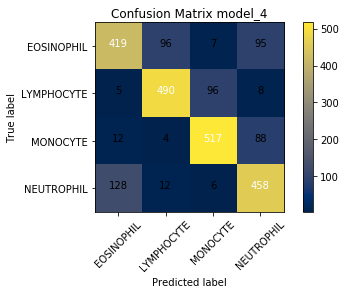

## Model 5

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 5, 64)          0         
___________________________

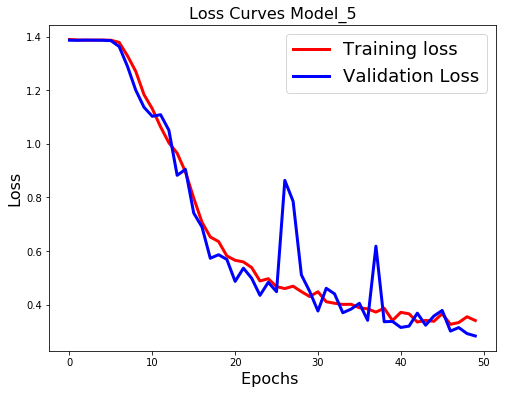

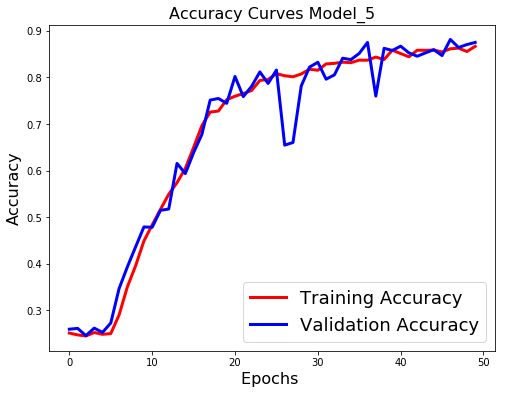

In [15]:
#model 5
model_name = 'Model_5'
model5 = Sequential()
model5.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model5.add(MaxPooling2D(pool_size=(2, 2)))


model5.add(Conv2D(32, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))



model5.add(Flatten())
model5.add(Dense(128, activation='relu'))


#add dropout 
model5.add(Dropout(0.5))

model5.add(Dense(4, activation='softmax'))
model5.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model5, model_name, image_generator, batch_size, epochs, 9957, 2487)

              precision    recall  f1-score   support

  EOSINOPHIL       0.65      0.70      0.68       617
  LYMPHOCYTE       0.76      0.75      0.76       599
    MONOCYTE       0.78      0.76      0.77       621
  NEUTROPHIL       0.70      0.67      0.69       604

   micro avg       0.72      0.72      0.72      2441
   macro avg       0.72      0.72      0.72      2441
weighted avg       0.72      0.72      0.72      2441

Confusion matrix, without normalization
[[434 129   4  50]
 [ 14 452 124   9]
 [ 27   7 473 114]
 [188   6   4 406]]


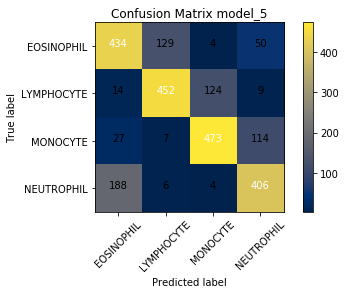

## Model 1b (adding batch normalization)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 78, 58, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 78, 58, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 27, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 37, 27, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7488)              0         
__________

Epoch 47/50
221/221 [==============================] - 150s 678ms/step - loss: 0.1897 - acc: 0.9252 - val_loss: 0.4774 - val_acc: 0.8146
Epoch 48/50
221/221 [==============================] - 152s 687ms/step - loss: 0.1952 - acc: 0.9270 - val_loss: 0.6765 - val_acc: 0.7473
Epoch 49/50
221/221 [==============================] - 148s 672ms/step - loss: 0.1783 - acc: 0.9310 - val_loss: 0.9515 - val_acc: 0.6730
Epoch 50/50
221/221 [==============================] - 150s 676ms/step - loss: 0.1829 - acc: 0.9305 - val_loss: 0.4028 - val_acc: 0.8492
0.849165227437884


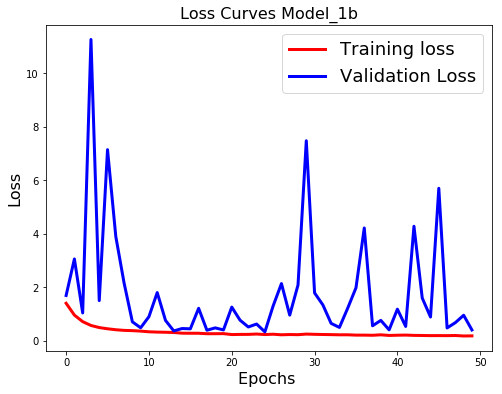

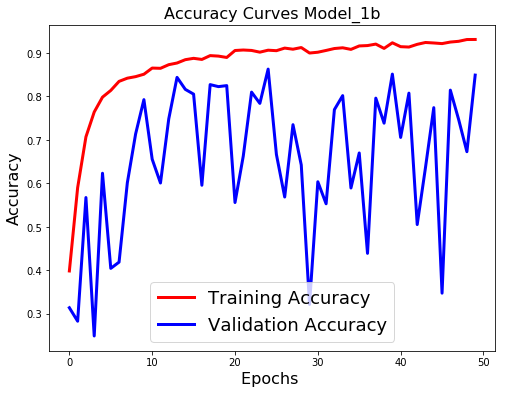

In [10]:
model_name = 'Model_1b'
model1b = Sequential()
model1b.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model1b.add(BatchNormalization())
model1b.add(MaxPooling2D(pool_size=(2, 2)))

model1b.add(Conv2D(32, (3, 3), activation='relu'))
model1b.add(BatchNormalization())
model1b.add(MaxPooling2D(pool_size=(2, 2)))

model1b.add(Flatten())
model1b.add(Dense(128, activation='relu'))
model1b.add(BatchNormalization())
model1b.add(Dense(4, activation='softmax'))
model1b.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model1b, model_name, image_generator, batch_size, epochs, 7087, 1769)

              precision    recall  f1-score   support

  EOSINOPHIL       0.70      0.96      0.81       617
  LYMPHOCYTE       0.99      0.88      0.93       599
    MONOCYTE       0.94      0.99      0.96       621
  NEUTROPHIL       0.96      0.64      0.77       604

   micro avg       0.87      0.87      0.87      2441
   macro avg       0.90      0.87      0.87      2441
weighted avg       0.90      0.87      0.87      2441

Confusion matrix, without normalization
[[593   2  11  11]
 [ 61 528   7   3]
 [  6   0 614   1]
 [192   3  21 388]]


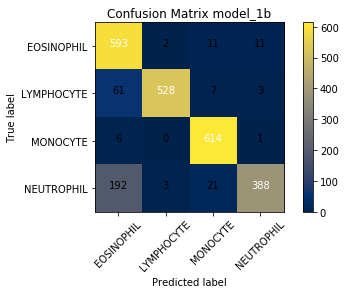

In [11]:
predict(model1b ,'model_1b',image_generator,2441,batch_size)

## Model 1C (Adam optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 13, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 7488)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               958592    
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 516       
Total para

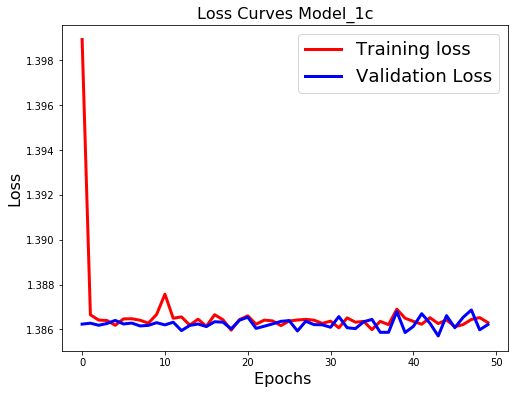

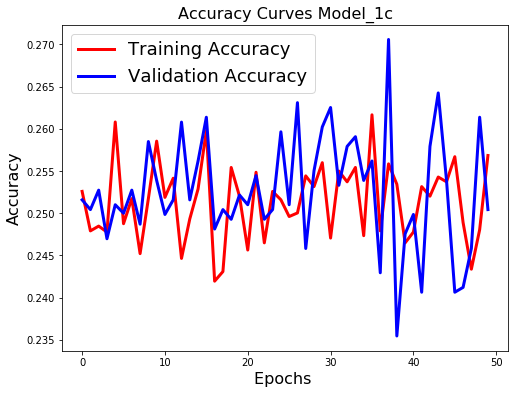

In [15]:
model_name = 'Model_1c'
model1c = Sequential()
model1c.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model1c.add(MaxPooling2D(pool_size=(2, 2)))

model1c.add(Conv2D(32, (3, 3), activation='relu'))
model1c.add(MaxPooling2D(pool_size=(2, 2)))

model1c.add(Flatten())
model1c.add(Dense(128, activation='relu'))
model1c.add(Dense(4, activation='softmax'))
model1c.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

fit(model1c, model_name, image_generator, batch_size, epochs, 7087, 1769)